In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.oauth2 import service_account
from google.cloud import bigquery

import ipdb

key_path = "/home/clementine/code/Clementinelalande/gcp/marbotic-4221eb142ed6.json"

credentials = service_account.Credentials.from_service_account_file(key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])

    

## Retrieve event table and prepare for aggregations


In [2]:
def extract():
    # Construct a BigQuery client object.
    key_path = "/home/clementine/code/Clementinelalande/gcp/marbotic-4221eb142ed6.json"
    

    credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    
    client = bigquery.Client(project="marbotic", credentials=credentials)

    query = """
        SELECT *
        FROM `marbotic.marbotic_dataset.events`
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)



In [6]:
# Remove duplicates
df = data.drop_duplicates()


In [7]:
#trouver la proportion de lignes nulles en% 
df.isnull().sum().sort_values(ascending = False)/len(data)*100


city                    1.089735
region                  0.910069
client_event_time       0.000000
country                 0.000000
device_model            0.000000
event_id                0.000000
event_type              0.000000
is_attribution_event    0.000000
language                0.000000
os_version              0.000000
session_id              0.000000
start_version           0.000000
user_creation_time      0.000000
user_id                 0.000000
id                      0.000000
dtype: float64

In [9]:
#drop lines with user_id equal to zero
df = df[df.user_id != 0].copy()


In [10]:
#replace by no_region if no region
df.region.replace(np.nan, "no_region", inplace=True) 

#replace by no_city if no city
df.city.replace(np.nan, "no_city", inplace=True) 


In [11]:
df.isnull().sum().sort_values(ascending = False)


city                    0
client_event_time       0
country                 0
device_model            0
event_id                0
event_type              0
is_attribution_event    0
language                0
os_version              0
region                  0
session_id              0
start_version           0
user_creation_time      0
user_id                 0
id                      0
dtype: int64

In [14]:
event_type_list = list(df.event_type.unique())


In [15]:
dict_event_simple = {'[Profile] Create' : "setup" ,                     
         '[Profile] Update' : "setup",                     
         '[Account] Sign In' : "setup",                    
         '[OB] ProfileName' : "setup",                     
         '[OB] ProfileBirthdate' : "setup",                    
         '[Activation] Game' : "game",                    
         '[OB] KeyRedeem' : "setup",                     
         '[OB] KeyFail' : "setup",                     
         '[OB] RenewalSelection' : "setup",                    
         '[Account] Sign Up' : "setup",                     
         '[OB] ProductSelection' : "setup",                    
         '[OB] ProductSK' : "setup",                    
         '[OB] ProductHelp' : "setup",                     
         '[OB] ProductActivation' : "setup",                     
         '[Game] Stop' : "game",
         '[OB] RenewalSuccess' : "setup",                     
         '[OB] ProductSeeMore' : "setup",                     
         '[OB] ProductOther' : "setup",                    
         '[Scaffolding] Reset' : "game",                    
         '[Account] Sign Out' : "setup",                     
         '[OB] CommPreview' : "setup",                    
         '[OB] DoYouHaveKit' : "setup",                    
         '[OB] HasKitYes' : "setup",                     
         '[OB] Email' : "setup",                    
         '[OB] VerifCode' : "setup",                     
         '[Activation] New Activation' : "setup",
         '[Activation] Product' : "setup",                     
         '[Activation] Piece' : "setup",                     
         '[OB] Success' : "setup",                    
         '[OB] RenewalFail' : "setup",                     
         '[OB] ClickTrial' : "setup",                     
         '[Popup] Open' : "setup",                    
         '[Popup] Close' : "setup",                   
         '[OB] HasKitNo' : "setup",                    
         '[OB] DiscoverTrial' : "setup",                    
         '[Account] Update Request' : "setup",                     
         '[Account] Update Success' : "setup",                    
         '[Profile] Delete' : "setup",                     
         '[OB] TrialStart' : "setup",                     
         '[OB] ClickStore' : "setup",                    
         '[OB] HasKeyNo' : "setup",                     
         '[OB] Type' : "setup",                     
         '[OB] KeySuccess' : "setup",                     
         '[Game] Pause' : "game",                    
         '[Game] Start' : "game",                    
         '[Error] Error' : "game",                     
         '[Scene] Enter' : "game",                     
         '[Scene] Leave' : "game",                    
         '[Action] Click' : "game",
         '[Activity] Stop' : "game", 
         '[Activity] Start' : "game",
         '[Activity] Good Answer' : "game", 
         '[Activity] Wrong Answer' : "game",
         '[Scaffolding] Scaffolding' : "game",                    
         '[Profile] Reset Settings and Progression' : "setup"}    


In [16]:
for el in event_type_list:
    if el not in list(dict_event_simple.keys()):        
        dict_event_simple[el] = "TO_BE_CHANGED"
        
dict_event_simple['[Toast] Appear'] = 'setup'
dict_event_simple['[Toast] Disappear'] = 'setup'
dict_event_simple['[Action] ConversionClickSubscribe'] = 'setup'
dict_event_simple['[Action] ConversionClickRedeem'] = 'setup'


In [17]:
df["event_simple"]=df["event_type"].map(dict_event_simple)


<AxesSubplot:xlabel='event_simple', ylabel='Count'>

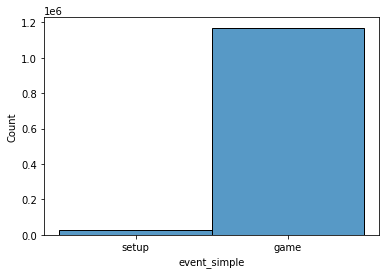

In [18]:
sns.histplot(data=df, x="event_simple")


<AxesSubplot:xlabel='event_type', ylabel='Count'>

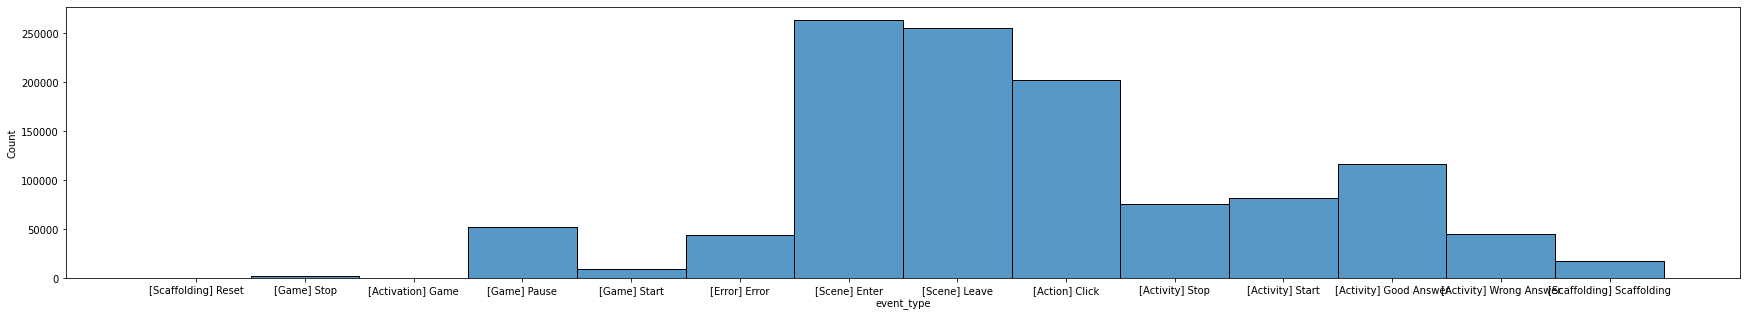

In [19]:
plt.figure(figsize=(30,5))

sns.histplot(data=df[df['event_simple']=='game'], x="event_type")


In [20]:
df[df['event_simple']=='game'].nunique()


city                       1749
client_event_time       1161188
country                      74
device_model                 33
event_id                  35272
event_type                   14
is_attribution_event          1
language                     16
os_version                   72
region                      395
session_id                18814
start_version                54
user_creation_time         2624
user_id                    2624
id                      1169806
event_simple                  1
dtype: int64

## Create user_metrics derivative table and upload to GBQ



In [21]:
#calculate game intensity metrics by player
#step 1 : one hot encode game feature
from sklearn.preprocessing import OneHotEncoder

# Instantiate encoder
ohe = OneHotEncoder(sparse = False) 

# Fit encoder all 55 features, not great (i want to use it only for the gaming events, but hey, you got what you got
ohe.fit(df[['event_type']]) 

# Encode + retrieve columns names
df_encoded = ohe.transform(df[['event_type']]) 
df_encoded = pd.DataFrame(df_encoded)

df_encoded.columns = ohe.get_feature_names_out()


In [22]:
df_final = pd.concat([df,df_encoded],axis=1)
df_final


,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,...,event_type_[Profile] Create,event_type_[Profile] Delete,event_type_[Profile] Reset Settings and Progression,event_type_[Profile] Update,event_type_[Scaffolding] Reset,event_type_[Scaffolding] Scaffolding,event_type_[Scene] Enter,event_type_[Scene] Leave,event_type_[Toast] Appear,event_type_[Toast] Disappear
1,London,2022-03-09 18:28:18.765000+00:00,United Kingdom,iPad 6,18.0,[Activation] New Activation,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,London,2022-03-09 18:28:18.766000+00:00,United Kingdom,iPad 6,19.0,[Activation] Product,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,London,2022-03-09 18:28:18.767000+00:00,United Kingdom,iPad 6,20.0,[Activation] Piece,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,London,2022-03-09 18:28:19.337000+00:00,United Kingdom,iPad 6,21.0,[OB] Success,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,London,2022-03-09 18:33:24.440000+00:00,United Kingdom,iPad 6,39.0,[OB] ProductSelection,False,English,14.1,England,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194015,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194016,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194017,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194018,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Renames columns to get rid of [] and avoid issues with Google big query upload later on
for col in list(df_final.columns):
    col_new = col.replace("[","").replace("]","").replace(" ","_")
    if col_new != col: 
        df_final[col_new] = df_final[col]
        del df_final[col]
df_final

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
1,London,2022-03-09 18:28:18.765000+00:00,United Kingdom,iPad 6,18.0,[Activation] New Activation,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,London,2022-03-09 18:28:18.766000+00:00,United Kingdom,iPad 6,19.0,[Activation] Product,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,London,2022-03-09 18:28:18.767000+00:00,United Kingdom,iPad 6,20.0,[Activation] Piece,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,London,2022-03-09 18:28:19.337000+00:00,United Kingdom,iPad 6,21.0,[OB] Success,False,English,14.1,England,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,London,2022-03-09 18:33:24.440000+00:00,United Kingdom,iPad 6,39.0,[OB] ProductSelection,False,English,14.1,England,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194015,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194016,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194017,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194018,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Group by user_id and add the count of nb of unique session, nb of unique event recorded for one user
user_base = pd.DataFrame(df_final.groupby("user_id").max()["user_creation_time"])
user_base

for col in ['id','session_id']:
    col_series = df_final.groupby("user_id").nunique()[col]
    user_base = pd.merge(user_base.copy(), col_series, on="user_id", how="left")

user_base


,user_creation_time,id,session_id
user_id,,,
211.0,2022-02-27 13:34:22.901000+00:00,824,8
274.0,2020-09-18 17:14:30.805000+00:00,40,7
453.0,2021-11-01 23:55:04.177000+00:00,153,3
564.0,2021-01-01 20:29:36.330000+00:00,52,1
609.0,2020-10-27 15:15:40.936000+00:00,69,1
...,...,...,...
73184.0,2022-05-12 16:20:23.231000+00:00,81,1
73185.0,2022-05-12 16:30:57.876000+00:00,122,1
73188.0,2022-05-12 21:02:44.492000+00:00,219,1


In [26]:
# Group by user_id and add the count of event_type : number of event register by event_type for one user
list_event = [col for col in list(df_final.columns) if col[:11] == "event_type_"]

list_event

for col in list_event:
    col_series = df_final.groupby("user_id").sum()[col]
    user_base = pd.merge(user_base.copy(), col_series, on="user_id", how="left")

user_base

,user_creation_time,id,session_id,event_type_Account_Sign_In,event_type_Account_Sign_Out,event_type_Account_Sign_Up,event_type_Account_Update_Request,event_type_Account_Update_Success,event_type_Action_Click,event_type_Action_ConversionClickRedeem,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
user_id,,,,,,,,,,,,,,,,,,,,,
211.0,2022-02-27 13:34:22.901000+00:00,824,8,0.0,0.0,0.0,0.0,0.0,173.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,320.0,127.0,0.0,0.0
274.0,2020-09-18 17:14:30.805000+00:00,40,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,31.0,6.0,0.0,0.0
453.0,2021-11-01 23:55:04.177000+00:00,153,3,0.0,0.0,0.0,0.0,0.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,35.0,0.0,0.0
564.0,2021-01-01 20:29:36.330000+00:00,52,1,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0
609.0,2020-10-27 15:15:40.936000+00:00,69,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73184.0,2022-05-12 16:20:23.231000+00:00,81,1,0.0,0.0,0.0,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,21.0,0.0,0.0
73185.0,2022-05-12 16:30:57.876000+00:00,122,1,0.0,0.0,0.0,0.0,0.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,34.0,0.0,0.0
73188.0,2022-05-12 21:02:44.492000+00:00,219,1,0.0,0.0,0.0,0.0,0.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,58.0,19.0,0.0,0.0


In [28]:
# Group by customerID and select only the information for the last timestamp
grouping =df_final.loc[df_final.groupby("user_id")["client_event_time"].idxmax()]
grouping = grouping[['user_id','client_event_time','city','language','os_version','region','country','device_model','start_version']]
grouping = grouping.merge(user_base,on="user_id",how='inner')
grouping


,user_id,client_event_time,city,language,os_version,region,country,device_model,start_version,user_creation_time,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
0,211.0,2022-03-13 13:32:14.916000+00:00,Norwich,English,14.7.1,Norfolk,United Kingdom,iPad 5,1.0.8,2022-02-27 13:34:22.901000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,320.0,127.0,0.0,0.0
1,274.0,2022-05-01 17:44:50.615000+00:00,Columbus,English,14.7.1,Ohio,United States,"iPad11,6",1.2.1,2020-09-18 17:14:30.805000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,31.0,6.0,0.0,0.0
2,453.0,2022-03-19 21:37:36.833000+00:00,Livermore,English,12.5.5,California,United States,iPad Air,1.3.0,2021-11-01 23:55:04.177000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,23.0,35.0,0.0,0.0
3,564.0,2022-04-23 15:37:54.445000+00:00,Carson City,English,14.8,Nevada,United States,iPad Air 2,1.0.1,2021-01-01 20:29:36.330000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,15.0,0.0,0.0
4,609.0,2022-05-07 16:33:03.540000+00:00,Westminster,English,15.4.1,Maryland,United States,iPad 6,2.1.0,2020-10-27 15:15:40.936000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,73184.0,2022-05-12 16:33:26.489000+00:00,Saint-Eustache,French,15.3.1,Quebec,Canada,iPad 5,2.0.6,2022-05-12 16:20:23.231000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,21.0,0.0,0.0
2622,73185.0,2022-05-12 17:04:58.087000+00:00,Thunder Bay,English,14.7.1,Ontario,Canada,iPad Air 2,2.0.6,2022-05-12 16:30:57.876000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,34.0,0.0,0.0
2623,73188.0,2022-05-12 23:13:13.334000+00:00,Seattle,English,13.4.1,Washington,United States,iPad Air 3,2.0.6,2022-05-12 21:02:44.492000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,58.0,19.0,0.0,0.0
2624,73197.0,2022-05-13 09:25:19.784000+00:00,Deinze,Dutch,15.4,East Flanders Province,Belgium,iPad Pro,2.0.6,2022-05-13 09:21:35.633000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
#Localisation du projet name et table_id sur gcp
project="marbotic"
table_id = "marbotic_dataset.users_metrics"
client = bigquery.Client(project,credentials)

job = client.load_table_from_dataframe(grouping, table_id) 

job.result()  # Wait for the job to complete.
table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

      
    

Loaded 2626 rows and 71 columns to marbotic_dataset.users_metrics


## Create session_metrics derivative table and upload to GBQ



In [49]:
#creating session derivative table

#add session end timestamp

session_base = pd.DataFrame(df_final.groupby("session_id").max()["client_event_time"]) #prendre le timestamp de fin de session
session_base

col_series = df_final.groupby("session_id").nunique()['id']   #compter le nb d'evenement par session
session_base = pd.merge(session_base.copy(), col_series, on="session_id", how="left")

add_user_id = pd.DataFrame(df_final.groupby("session_id").max()["user_id"]) #prendre le user_id qui correspond à la session
session_base = pd.merge(session_base.copy(), add_user_id, on="session_id", how="left")

session_base

,client_event_time,id,user_id
session_id,,,
1.641524e+12,2022-01-07 02:56:29.983000+00:00,2,67750.0
1.641826e+12,2022-01-10 15:05:31.598000+00:00,1,55884.0
1.641931e+12,2022-01-11 20:00:30.512000+00:00,97,65632.0
1.641932e+12,2022-01-11 20:06:04.323000+00:00,2,65632.0
1.642001e+12,2022-01-12 15:34:25.246000+00:00,5,66337.0
...,...,...,...
1.652434e+12,2022-05-13 09:52:12.279000+00:00,26,65663.0
1.652434e+12,2022-05-13 09:52:15.555000+00:00,28,65663.0
1.652435e+12,2022-05-13 09:55:59.033000+00:00,24,73198.0


In [50]:
#add individual OHE events counts

for col in list_event:
    col_series = df_final.groupby("session_id").sum()[col]  #compte les evenements par session, une colonne = 1 event_type
    session_base = pd.merge(session_base.copy(), col_series, on="session_id", how="left")

session_base




,client_event_time,id,user_id,event_type_Account_Sign_In,event_type_Account_Sign_Out,event_type_Account_Sign_Up,event_type_Account_Update_Request,event_type_Account_Update_Success,event_type_Action_Click,event_type_Action_ConversionClickRedeem,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
session_id,,,,,,,,,,,,,,,,,,,,,
1.641524e+12,2022-01-07 02:56:29.983000+00:00,2,67750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1.641826e+12,2022-01-10 15:05:31.598000+00:00,1,55884.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1.641931e+12,2022-01-11 20:00:30.512000+00:00,97,65632.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,15.0,0.0,0.0
1.641932e+12,2022-01-11 20:06:04.323000+00:00,2,65632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.642001e+12,2022-01-12 15:34:25.246000+00:00,5,66337.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.652434e+12,2022-05-13 09:52:12.279000+00:00,26,65663.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0
1.652434e+12,2022-05-13 09:52:15.555000+00:00,28,65663.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0
1.652435e+12,2022-05-13 09:55:59.033000+00:00,24,73198.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0


In [51]:
# Group by customerID and select only the information for the last timestamp : prendre la derniere version
grouping =df_final.loc[df_final.groupby("session_id")["client_event_time"].idxmax()]
grouping = grouping[['session_id','city','language','os_version','region','country','device_model','start_version']]
session_base = grouping.merge(session_base.copy(),on="session_id",how='inner')
session_base



,session_id,city,language,os_version,region,country,device_model,start_version,client_event_time,id,...,event_type_Profile_Create,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,15.0,0.0,0.0
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0


In [52]:
init_session = pd.DataFrame(df_final.groupby("session_id").min()["client_event_time"])#prendre le 1e ts de la session = start
init_session

session_base = pd.merge(session_base.copy(), init_session, on="session_id", how="left")

session_base

,session_id,city,language,os_version,region,country,device_model,start_version,client_event_time_x,id,...,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,client_event_time_y
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2022-01-07 02:56:28.793000+00:00
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2022-01-10 15:05:31.598000+00:00
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,40.0,15.0,0.0,0.0,2022-01-11 19:49:46.744000+00:00
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-11 20:06:03.428000+00:00
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2022-01-12 15:34:18.911000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,2022-05-13 09:31:25.198000+00:00
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,2022-05-13 09:31:39.459000+00:00
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,2022-05-13 09:51:46.132000+00:00
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,2022-05-13 09:45:31.947000+00:00


In [53]:
session_base.rename(columns ={"client_event_time_y": "session_start","client_event_time_x" :"session_end"}, inplace = True)
session_base


,session_id,city,language,os_version,region,country,device_model,start_version,session_end,id,...,event_type_Profile_Delete,event_type_Profile_Reset_Settings_and_Progression,event_type_Profile_Update,event_type_Scaffolding_Reset,event_type_Scaffolding_Scaffolding,event_type_Scene_Enter,event_type_Scene_Leave,event_type_Toast_Appear,event_type_Toast_Disappear,session_start
0,1.641524e+12,Eugene,English,15.2,Oregon,United States,iPad Pro,1.0.7,2022-01-07 02:56:29.983000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2022-01-07 02:56:28.793000+00:00
1,1.641826e+12,Lithonia,English,12.5.5,Georgia,United States,iPad Mini 2,1.2.0,2022-01-10 15:05:31.598000+00:00,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2022-01-10 15:05:31.598000+00:00
2,1.641931e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:00:30.512000+00:00,97,...,0.0,0.0,0.0,0.0,0.0,40.0,15.0,0.0,0.0,2022-01-11 19:49:46.744000+00:00
3,1.641932e+12,Oakville,English,13.5.1,Ontario,Canada,iPad Air 2,1.0.1,2022-01-11 20:06:04.323000+00:00,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-01-11 20:06:03.428000+00:00
4,1.642001e+12,Parignargues,French,15.2,Gard,France,iPad 6,1.0.3,2022-01-12 15:34:25.246000+00:00,5,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2022-01-12 15:34:18.911000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:12.279000+00:00,26,...,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,2022-05-13 09:31:25.198000+00:00
18812,1.652434e+12,Montreal,French,10.3.3,Aude,France,iPad 4,1.0.1,2022-05-13 09:52:15.555000+00:00,28,...,0.0,0.0,0.0,0.0,0.0,8.0,6.0,0.0,0.0,2022-05-13 09:31:39.459000+00:00
18813,1.652435e+12,Medina,English,15.4.1,Medina Region,Saudi Arabia,"iPad12,1",2.0.6,2022-05-13 09:55:59.033000+00:00,24,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,2022-05-13 09:51:46.132000+00:00
18814,1.652435e+12,Melbourne,Chinese,12.5.5,Victoria,Australia,iPad Air,2.0.5,2022-05-13 09:58:43.012000+00:00,39,...,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,2022-05-13 09:45:31.947000+00:00


In [54]:
#Localisation du projet name et table_id sur gcp
project="marbotic"
table_id = "marbotic_dataset.sessions_metrics"
client = bigquery.Client(project,credentials)

job = client.load_table_from_dataframe(session_base, table_id) 

job.result()  # Wait for the job to complete.
table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))



Loaded 18816 rows and 71 columns to marbotic_dataset.sessions_metrics
